In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm
import os
import sys


import olga.load_model as load_model
import olga.generation_probability as pgen
import olga.sequence_generation as seq_gen


from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")



There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import copy
import datetime
import random
import re
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import datasets
import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW, BertConfig
from transformers import BertForSequenceClassification, BertTokenizer, AutoModelForSequenceClassification, AutoTokenizer
from transformers.modeling_outputs import TokenClassifierOutput, SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed
from transformers import DataCollatorForTokenClassification
import tensorflow as tf

from sklearn.metrics import f1_score, accuracy_score
from scipy import stats

from evaluate import load
from datasets import Dataset



[2024-09-02 13:22:55,852] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
# !git clone git@hf.co:wukevin/tcr-bert

In [5]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [6]:
import os.path
#os.chdir("./")
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [7]:
from utilites import balance_majority, balance_minority, process_types, add_spaces, mask_seqs

In [8]:
# from my_model import save_model, load_model_

In [9]:
vdjdb = pd.read_csv('../data/vdjdb_full_upd.txt', sep='\t', low_memory=False)
vdjdb.head()

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,...,meta.replica.id,meta.clone.id,meta.epitope.id,meta.tissue,meta.donor.MHC,meta.donor.MHC.method,meta.structure.id,cdr3fix.alpha,cdr3fix.beta,vdjdb.score
0,CAVQDLGTSGSRLTF,TRAV20*01,NaN,CASSARSGELFF,TRBV9*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-B*35:01,B2M,...,NaN,TK3,NaN,PBMC,HLA-B*35:01,sanger,NaN,"{""cdr3"": ""CAVQDLGTSGSRLTF"", ""cdr3_old"": ""CAVQD...","{""cdr3"": ""CASSARSGELFF"", ""cdr3_old"": ""CASSARSG...",1
1,CAVQDLGTSGSRLTF,TRAV20*01,NaN,CASSARSGELFF,TRBV9*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-B*35:01,B2M,...,NaN,TK6,NaN,PBMC,HLA-B*35:01,sanger,NaN,"{""cdr3"": ""CAVQDLGTSGSRLTF"", ""cdr3_old"": ""CAVQD...","{""cdr3"": ""CASSARSGELFF"", ""cdr3_old"": ""CASSARSG...",1
2,CAVQDLQTSGSRLTF,TRAV20*01,NaN,CASSAPTGELFF,TRBV9*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-B*35:01,B2M,...,NaN,CS1,NaN,PBMC,HLA-B*35:01,sanger,NaN,"{""cdr3"": ""CAVQDLQTSGSRLTF"", ""cdr3_old"": ""CAVQD...","{""cdr3"": ""CASSAPTGELFF"", ""cdr3_old"": ""CASSAPTG...",1
3,CAVQSLETSGSRLTF,TRAV20*01,NaN,CASSARTGELFF,TRBV9*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-B*35:01,B2M,...,NaN,MW1,NaN,PBMC,HLA-B*35:01,sanger,NaN,"{""cdr3"": ""CAVQSLETSGSRLTF"", ""cdr3_old"": ""CAVQS...","{""cdr3"": ""CASSARTGELFF"", ""cdr3_old"": ""CASSARTG...",1
4,NaN,NaN,NaN,CASSPRRYNEQFF,TRBV9*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-B*35:08,B2M,...,NaN,SB5,NaN,PBMC,HLA-B*35:08,sanger,NaN,NaN,"{""cdr3"": ""CASSPRRYNEQFF"", ""cdr3_old"": ""CASSPRR...",1


In [10]:
vdjdb.shape

(68306, 34)

In [11]:
vdjb_short = vdjdb[['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 
       'j.beta', 'antigen.epitope', 'antigen.species']]


# vdjb_short = vdjb_short[vdjb_short['antigen.epitope'] != 'KLGGALQAK']
vdjb_short.shape

(68306, 8)

In [12]:
vdjb_short_a = vdjdb[['cdr3.alpha', 'v.alpha', 'j.alpha', 'antigen.epitope', 'antigen.species']]
vdjb_short_b = vdjdb[['cdr3.beta', 'v.beta', 'j.beta', 'antigen.epitope', 'antigen.species']]


In [13]:
vdjb_short_a.isna().sum()

cdr3.alpha         25909
v.alpha            25946
j.alpha            27010
antigen.epitope        0
antigen.species        0
dtype: int64

In [14]:
vdjb_short_b#.isna().sum()

,cdr3.beta,v.beta,j.beta,antigen.epitope,antigen.species
0,CASSARSGELFF,TRBV9*01,TRBJ2-2*01,HPVGEADYFEY,EBV
1,CASSARSGELFF,TRBV9*01,TRBJ2-2*01,HPVGEADYFEY,EBV
2,CASSAPTGELFF,TRBV9*01,TRBJ2-2*01,HPVGEADYFEY,EBV
3,CASSARTGELFF,TRBV9*01,TRBJ2-2*01,HPVGEADYFEY,EBV
4,CASSPRRYNEQFF,TRBV9*01,TRBJ2-1*01,HPVGEADYFEY,EBV
...,...,...,...,...,...
68301,CATSRGGAYEQYF,TRBV15*01,TRBJ2-7*01,LLWNGPMAV,YFV
68302,CASSWVGNEQFF,TRBV5-6*01,TRBJ2-1*01,LLWNGPMAV,YFV
68303,CASGIPSTTGAVGTDTQYF,TRBV28*01,TRBJ2-3*01,LLWNGPMAV,YFV
68304,CASSEGLAAYEQYF,TRBV10-2*01,TRBJ2-7*01,LLWNGPMAV,YFV


In [15]:
vdjb_short_a = vdjb_short_a.dropna()
vdjb_short_b = vdjb_short_b.dropna()

In [16]:
vdjb_short_a = vdjb_short_a.rename(columns = {'cdr3.alpha': 'cdr3aa', 'v.alpha': 'v', 'j.alpha': 'j'})
vdjb_short_b = vdjb_short_b.rename(columns = {'cdr3.beta': 'cdr3aa', 'v.beta': 'v', 'j.beta': 'j'})

In [17]:
vdjb_short_a['v'] = vdjb_short_a['v'].apply(process_types, 'A')
vdjb_short_b['v'] = vdjb_short_b['v'].apply(process_types, 'B')

vdjb_short_a['j'] = vdjb_short_a['j'].apply(process_types, 'A')
vdjb_short_b['j'] = vdjb_short_b['j'].apply(process_types, 'B')

<BarContainer object of 29 artists>

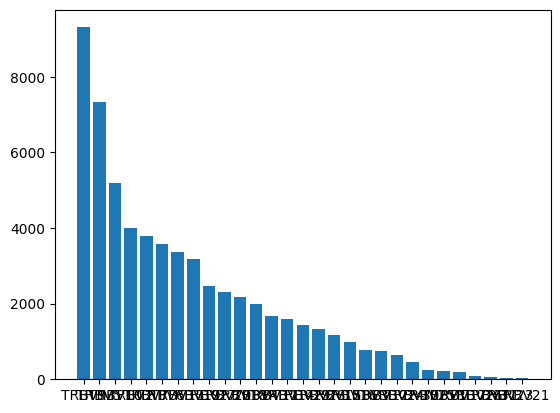

In [18]:
plt.bar(vdjb_short_b.v.unique(), vdjb_short_b.v.value_counts())

In [19]:
alpha_resampl = balance_majority(vdjb_short_a, 'v', min_count=100, max_count=1200)
beta_resampl = balance_majority(vdjb_short_b, 'v', min_count=100, max_count=2000)


In [20]:
alpha_resampl = balance_majority(alpha_resampl, 'j', min_count=100, max_count=1000)
beta_resampl = balance_majority(beta_resampl, 'j', min_count=10, max_count=8000)


<BarContainer object of 32 artists>

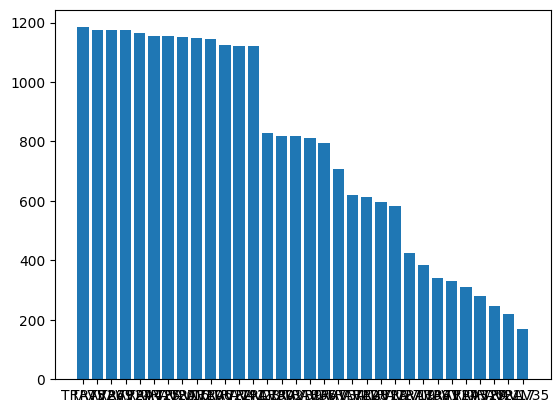

In [21]:
plt.bar(alpha_resampl.v.unique(), alpha_resampl.v.value_counts())

<BarContainer object of 25 artists>

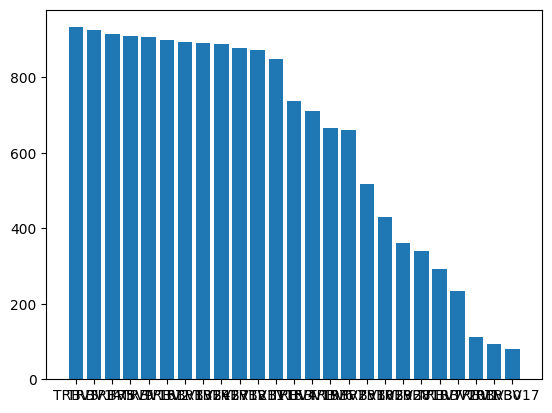

In [22]:
plt.bar(beta_resampl.v.unique(), beta_resampl.v.value_counts())

In [23]:
beta_resampl

,cdr3aa,v,j,antigen.epitope,antigen.species
19406,CASSQASGAGEKRSSYNEQFF,TRBV3,TRBJ2,KLGGALQAK,CMV
38709,CASSQGTISYEQYF,TRBV14,TRBJ2,LLWNGPMAV,YFV
63986,CASSLGPTGELFF,TRBV5,TRBJ2,GILGFVFTL,InfluenzaA
19,CASSARSGELFF,TRBV9,TRBJ2,HPVGEADYFEY,EBV
47835,CASSLAGQGDNYEQYF,TRBV5,TRBJ2,GLCTLVAML,EBV
...,...,...,...,...,...
23857,CASSGGNILDGYTF,TRBV6,TRBJ1,IVTDFSVIK,EBV
20147,CASSFGRGNTEAFF,TRBV27,TRBJ1,KLGGALQAK,CMV
64906,CASSLSKNTEAFF,TRBV12,TRBJ1,TPQDLNTML,HIV-1
32277,CASSPWDSRFYGYTF,TRBV9,TRBJ1,GILGFVFTL,InfluenzaA


In [24]:
alpha_resampl

,cdr3aa,v,j,antigen.epitope,antigen.species
350,CAEILMDSNYQLIW,TRAV5,TRAJ33,DATYQRTRALVR,InfluenzaA
7542,CAETQDSNYQLIW,TRAV5,TRAJ33,RAKFKQLL,EBV
7770,CAETQDSNYQLIW,TRAV5,TRAJ33,RAKFKQLL,EBV
8066,CAETQDSNYQLIW,TRAV5,TRAJ33,GILGFVFTL,InfluenzaA
8123,CAETQDSNYQLIW,TRAV5,TRAJ33,RAKFKQLL,EBV
...,...,...,...,...,...
62311,CAFMMSAGGTSYGKLTF,TRAV38,TRAJ52,GILGFVFTL,InfluenzaA
13352,CADAGGTSYGKLTF,TRAV12,TRAJ52,KLGGALQAK,CMV
8679,CVGGTSYGKLTF,TRAV10,TRAJ52,RAKFKQLL,EBV
16863,CAFIGDAGGTSYGKLTF,TRAV24,TRAJ52,KLGGALQAK,CMV


In [25]:
ab_data = pd.concat([alpha_resampl, beta_resampl], ignore_index=True)

In [26]:
# ab_data = pd.concat([vdjb_short_a, vdjb_short_b], ignore_index=True)

In [27]:
# ab_data['vj'] = ab_data['v'] + ab_data['j']

In [28]:
test_df = ab_data.sample(frac=0.2, random_state=42)
ab_data = ab_data.drop(test_df.index)
ab_data = ab_data.reset_index(drop=True)

In [30]:
ab_v = ab_data[['cdr3aa', 'v']]
ab_j = ab_data[['cdr3aa', 'j']]

In [31]:
# ab_j_resampled = balance_minority(ab_j, 'j', max_count=600)
# ab_j_resampled = balance_majority(ab_j_resampled, 'j', max_count=800)
# ab_j_resampled.to_csv('ab_j_resampled.csv', index=False)

In [32]:
# ab_v_resampled = balance_minority(ab_v, 'v', max_count=600) #or 600
# ab_v_resampled = balance_majority(ab_v_resampled, 'v', max_count=800)
# ab_v_resampled.to_csv('ab_v_resampled.csv', index=False)

In [33]:
ab_v_resampled = pd.read_csv('ab_v_resampled.csv')
ab_j_resampled = pd.read_csv('ab_j_resampled.csv')

<BarContainer object of 57 artists>

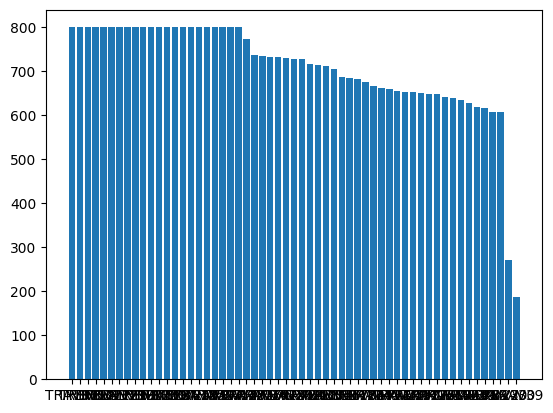

In [34]:
plt.bar(ab_v_resampled.v.unique(), ab_v_resampled.v.value_counts())

In [35]:
test_df_v = test_df[['cdr3aa', 'v']]
test_df_j = test_df[['cdr3aa', 'j']]

## V genes

In [36]:
#from sklearn.preprocessing import LabelEncoder
v_resampled = ab_v_resampled.copy()
# v_resampled['cdr3aa'] = v_resampled['cdr3aa'].apply(add_spaces)
# test_df_v['cdr3aa'] = test_df_v['cdr3aa'].apply(add_spaces)

l_enc = LabelEncoder()
l_enc.fit(v_resampled['v'])
v_resampled['v'] = l_enc.transform(v_resampled['v'])
test_df_v['v'] = l_enc.transform(test_df_v['v'])


/scratch/ipykernel_2304078/22818047.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_v['v'] = l_enc.transform(test_df_v['v'])


In [37]:
test_df_v = test_df_v.reset_index(drop=True)
v_ans = test_df_v.v
test_df_v = test_df_v.drop(columns=['v'])

In [38]:
N_LABELS = v_resampled['v'].nunique()

In [39]:
# new changes

In [44]:
from transformers import BertForSequenceClassification, BertTokenizer

class CustomModel(nn.Module):
    def __init__(self, n_labels = 2):
        super().__init__()
        self.n_labels = n_labels
        PATH = 'bert_large/'
        self.tokenizer = BertTokenizer.from_pretrained(PATH, local_files_only=True)
        self.model = BertForSequenceClassification.from_pretrained(PATH, num_labels = n_labels, local_files_only=True)                                                                            # output_hidden_states = True)
        self.training_stats = None
        self.maximun_len = None
        
    def count_max_len(self, seqs):
        max_len = 0
        for seq in seqs:
            input_ids = self.tokenizer.encode(seq, add_special_tokens=True)
            max_len = max(max_len, len(input_ids))
        return max_len
        
    def tokenize(self, seqs, labels, max_len = None):
        input_ids = []
        attention_masks = []
        if not max_len:
            max_len = self.count_max_len(seqs)
        self.maximun_len = max_len

        for seq in seqs:
            encoded_dict = self.tokenizer.encode_plus(seq, add_special_tokens = True, truncation=True, max_length = max_len, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')

            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the lists into tensors.
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)
        return (input_ids, attention_masks, labels)
    
    def split_data(self, input_ids, attention_masks, labels, n_train=0.8, n_val=0.2):
        dataset = TensorDataset(input_ids, attention_masks, labels)

        train_size = int(n_train * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))
        
        return train_dataset, val_dataset
    
    def fit(self, train_dataset, val_dataset, epochs = 4, batch_size = 16):
        device = torch.device("cuda")
        self.model.to(device)
        
        train_dataloader = DataLoader(train_dataset,
                sampler = RandomSampler(train_dataset),
                batch_size = batch_size)

        validation_dataloader = DataLoader(val_dataset,
                    sampler = SequentialSampler(val_dataset),
                    batch_size = batch_size)
        
        optimizer = torch.optim.AdamW (self.model.parameters(), lr = 3e-5, eps = 1e-8)
        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
        


        training_stats = []

        total_t0 = time.time()


        for epoch_i in range(0, epochs):
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')

            t0 = time.time()

            # Reset the total loss for this epoch.
            total_train_loss = 0

            self.model.train()

            for step, batch in enumerate(train_dataloader):
                if step % 40 == 0 and not step == 0:

                    # Calculate elapsed time in minutes.
                    elapsed = format_time(time.time() - t0)

                batch = tuple(t.to(device) for t in batch)

                b_input_ids, b_input_mask, b_labels = batch

                self.model.zero_grad()
                
                res = self.model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                
                loss = res['loss']
                logits = res['logits']

                total_train_loss += loss.item()

                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

                optimizer.step()
                # Update the learning rate.
                scheduler.step()

            # Calculate the average loss over all of the batches.
            avg_train_loss = total_train_loss / len(train_dataloader)

            # Measure how long this epoch took.
            training_time = format_time(time.time() - t0)

            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epcoh took: {:}".format(training_time))



            #Validation
            print("")
            print("Running Validation...")

            t0 = time.time()

            self.model.eval()

            # Tracking variables
            total_eval_accuracy = 0
            total_eval_loss = 0
            nb_eval_steps = 0

            # Evaluate data for one epoch
            for batch in validation_dataloader:
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch


                with torch.no_grad():
                    res = self.model(b_input_ids,
                                           token_type_ids=None,
                                           attention_mask=b_input_mask,
                                           labels=b_labels)
                loss = res['loss']
                logits = res['logits']

                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # Calculate the accuracy.
                total_eval_accuracy += flat_accuracy(logits, label_ids)


            # Report the final accuracy for this validation run.
            avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

            # Calculate the average loss over all of the batches.
            avg_val_loss = total_eval_loss / len(validation_dataloader)

            # Measure how long the validation run took.
            validation_time = format_time(time.time() - t0)

            print("  Validation Loss: {0:.2f}".format(avg_val_loss))
            print("  Validation took: {:}".format(validation_time))

            # Record all statistics from this epoch.
            training_stats.append(
                {'epoch': epoch_i + 1,
                    'Training Loss': avg_train_loss,
                    'Valid. Loss': avg_val_loss,
                    'Valid. Accur.': avg_val_accuracy,
                    'Training Time': training_time,
                    'Validation Time': validation_time})

        print("")
        print("Training complete!")
        self.training_stats = training_stats
    
    
    def get_stats(self):
        return pd.DataFrame(data=self.training_stats).set_index('epoch')
        
        
    def draw_stats_plot(self):
        if self.training_stats is None:
            print("No training statistics available.")
            return None

        epochs = range(1, len(self.training_stats) + 1)
        training_loss = [stats['Training Loss'] for stats in self.training_stats]
        validation_loss = [stats['Valid. Loss'] for stats in self.training_stats]
        validation_accuracy = [stats['Valid. Accur.'] for stats in self.training_stats]

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, training_loss, 'b-', label='Training Loss')
        plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
            
            
    def predict(self, test, epochs = 4, batch_size = 16):        
        input_ids = []
        attention_masks = []
        predictions = []
        predictions_logits = []
        
        for seq in test:
            #print(seq)
            encoded_dict = self.tokenizer.encode_plus(seq, add_special_tokens = True, 
                                  max_length = self.maximun_len, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')

            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])

        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
            
        test_dataset = TensorDataset(input_ids, attention_masks)
        
        
        device = torch.device("cuda")
        test_dataloader = DataLoader(test_dataset, 
                             sampler=SequentialSampler(test_dataset), 
                             batch_size=batch_size)
        self.model.eval()
        
            
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)

            b_input_ids, b_input_mask = batch

            # not to compute gradients
            with torch.no_grad():
                  # Forward pass, calculate logit predictions
                outputs = self.model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask)

            logits = outputs.logits
            predictions_logits.extend(logits.cpu().numpy())
            batch_predictions = torch.argmax(logits, dim=1)
            predictions.extend(batch_predictions.cpu().numpy())

        return predictions 
    
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [48]:
sequences = v_resampled['cdr3aa'].apply(mask_seqs)


In [49]:
sequences[5]

['C [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] A V A L H G S G N T G K L I F',
 'C A [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] V A L H G S G N T G K L I F',
 'C A V [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] A L H G S G N T G K L I F',
 'C A V A [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] L H G S G N T G K L I F',
 'C A V A L [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] H G 

In [50]:
V_model = CustomModel(n_labels=N_LABELS)
tensors = []
for masked_seq in sequences:
    tensor = torch.tensor([V_model.tokenizer.encode_plus(seq, add_special_tokens = True, 
                              max_length = 40, pad_to_max_length = True)['input_ids'] for seq in masked_seq])
    tensors.append(tensor)
result_tensor = torch.stack(tensors)


Some weights of the model checkpoint at bert_large/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert_large/ and are newly initial

In [51]:
v_resampled['cdr3aa'] = v_resampled['cdr3aa'].apply(add_spaces)

In [52]:
v_resampled

,cdr3aa,v
0,C A A S S D D R G S T L G R L Y F,22
1,C A A S D T G R R A L T F,22
2,C A L H S N Y Q L I W,22
3,C A V F S S N T G K L I F,22
4,C A A F D S G N T G K L I F,22
...,...,...
40422,C A V V N A R L M F,24
40423,C A V A D S G G S N Y K L T F,24
40424,C A P R C G G G A D G L T F,24
40425,C A V E I R G S Q G N L I F,24


In [55]:
_, attention_masks, labels = V_model.tokenize(v_resampled['cdr3aa'], v_resampled['v'], max_len=40)

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [58]:
attention_masks = attention_masks.repeat(1, 10)

In [60]:
input_ids = torch.reshape(result_tensor, (result_tensor.shape[0], result_tensor.shape[1]*result_tensor.shape[2]))

In [71]:
train_dataset, val_dataset = V_model.split_data(input_ids, attention_masks, labels)

32,341 training samples
8,086 validation samples


In [ ]:
V_model.fit(train_dataset, val_dataset, epochs=8, batch_size=16)


======== Epoch 1 / 8 ========
Training...

  Average training loss: 2.36
  Training epcoh took: 0:38:35

Running Validation...
  Accuracy: 0.41
  Validation Loss: 2.00
  Validation took: 0:03:15

======== Epoch 2 / 8 ========
Training...

  Average training loss: 1.93
  Training epcoh took: 0:38:31

Running Validation...
  Accuracy: 0.45
  Validation Loss: 1.89
  Validation took: 0:03:15

======== Epoch 3 / 8 ========
Training...

  Average training loss: 1.81
  Training epcoh took: 0:38:35

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.79
  Validation took: 0:03:15

======== Epoch 4 / 8 ========
Training...

  Average training loss: 1.71
  Training epcoh took: 0:38:34

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.75
  Validation took: 0:03:15

======== Epoch 5 / 8 ========
Training...

  Average training loss: 1.61
  Training epcoh took: 0:38:35

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.68
  Validation took: 0:03:15

======== Epoch 6 / 

In [86]:
V_model.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.251684,1.884976,0.458375,0:01:20,0:00:06
2,1.780082,1.758601,0.487008,0:01:21,0:00:06
3,1.635530,1.707581,0.500415,0:01:21,0:00:06
4,1.507375,1.650731,0.511038,0:01:21,0:00:06
5,1.386501,1.604872,0.531531,0:01:22,0:00:06
6,1.273053,1.582989,0.541727,0:01:21,0:00:06
7,1.176226,1.572237,0.552652,0:01:21,0:00:06
8,1.102272,1.570079,0.552405,0:01:21,0:00:06


In [1]:
#     def predict(mod, test_seqs, epochs = 4, batch_size = 16):        
#         input_ids = []
#         attention_masks = []
#         predictions = []
#         predictions_logits = []
#         tensors = []
#         for masked_seq in test_seqs:
#             tensor = torch.tensor([mod.tokenizer.encode_plus(seq, add_special_tokens = True, 
#                                       max_length = mod.maximun_len, pad_to_max_length = True)['input_ids'] for seq in masked_seq])
#             tensors.append(tensor)
#         result_tensor = torch.stack(tensors)
#         print(result_tensor.shape)
#         input_ids = torch.reshape(result_tensor, (result_tensor.shape[0], result_tensor.shape[1]*result_tensor.shape[2]))
        
#         for seq in test_seqs:
#             seq = seq[0]
#             encoded_dict = mod.tokenizer.encode_plus(seq, add_special_tokens = True, 
#                                   max_length = 42, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')

#             attention_masks.append(encoded_dict['attention_mask'])

        
#         attention_masks = torch.cat(attention_masks, dim=0).repeat(1, 10)
#         print(input_ids.shape, attention_masks.shape)

            
#         test_dataset = TensorDataset(input_ids, attention_masks)
                
#         device = torch.device("cuda")
#         test_dataloader = DataLoader(test_dataset, 
#                              sampler=SequentialSampler(test_dataset), 
#                              batch_size=batch_size)
#         mod.model.eval()
        
            
#         for batch in test_dataloader:
#             batch = tuple(t.to(device) for t in batch)

#             b_input_ids, b_input_mask = batch

#             # not to compute gradients
#             with torch.no_grad():
#                   # Forward pass, calculate logit predictions
#                 outputs = mod.model(b_input_ids, token_type_ids=None,
#                                   attention_mask=b_input_mask)

#             logits = outputs.logits
#             predictions_logits.extend(logits.cpu().numpy())
#             batch_predictions = torch.argmax(logits, dim=1)
#             predictions.extend(batch_predictions.cpu().numpy())

#         return predictions